In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import distribution_to_loans_outcomes as dlo

DATA_DIR = '../data/'

Populating the interactive namespace from numpy and matplotlib


In [3]:
# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

In [4]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);

In [5]:
cdfs = all_cdfs[["White","Black"]]

# B is White
# A is Black

cdf_B = cdfs['White'].values
cdf_A = cdfs['Black'].values

repay_B = performance['White']
repay_A = performance['Black']

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

In [6]:
# to populate group distributions
def get_pmf(cdf):
    pis = np.zeros(cdf.size)
    pis[0] = cdf[0]
    for score in range(cdf.size-1):
        pis[score+1] = cdf[score+1] - cdf[score]
    return pis

# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repay_A[scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repay_B[scores[scores.get_loc(i,method='nearest')]]]

In [7]:
# basic parameters
N_scores = cdf_B.size
N_groups = 2

# get probability mass functions of each group
pi_A = get_pmf(cdf_A)
pi_B = get_pmf(cdf_B)
pis = np.vstack([pi_A, pi_B])

# demographic statistics 
group_ratio = np.array((totals["Black"], totals["White"]))
group_size_ratio = group_ratio/group_ratio.sum()
print(group_size_ratio)

[0.12066905 0.87933095]


In [8]:
# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repay_A[scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repay_B[scores[scores.get_loc(i,method='nearest')]]]

# unpacking repay probability as a function of score
loan_repay_fns = [lambda x: loan_repaid_prob(x) for
                      loan_repaid_prob in loan_repaid_probs]

In [9]:
# all of the above is from Lydia's code in delayed-impact repos
# all of the below is my code transforming the data and running linear regression on it!
# NOTE: references for certain chunks will be included

In [10]:
import pandas as pd

In [11]:
def get_repay_probabilities(samples, repay_probs):
    sample_probs = []
    for index, score in enumerate(samples):
        prob_index = np.where(scores_arr == score)
        repay_prob = repay_probs[prob_index[0][0]]
        sample_probs.insert(index, repay_prob)
    return sample_probs

In [14]:
# Convert data in format needed
# Make repay probabilities into percentages from decimals
# NOTE: A is Black, B is White

scores_arr = np.asarray(scores_list)
repay_A_arr = pd.Series.to_numpy(repay_A)*100
repay_B_arr = pd.Series.to_numpy(repay_B)*100

In [15]:
# Sample data according to the pmf
# Reference: https://www.w3schools.com/python/ref_random_choices.asp

from random import choices

num_A_samples = 120
num_B_samples = 880

samples_A = np.asarray(sorted(choices(scores_arr, pi_A, k=num_A_samples)))
samples_B = np.asarray(sorted(choices(scores_arr, pi_B, k=num_B_samples)))

In [16]:
# Calculate samples groups' probabilities and make arrays for race
# A == Black == 0 (later defined as 0.0 when converting to pandas df)
# B == White == 1 (later defined as 1.0 when converting to pandas df)

samples_A_probs = np.asarray(get_repay_probabilities(samples=samples_A, repay_probs=repay_A_arr))
samples_A_race = np.asarray([0] * num_A_samples)

samples_B_probs = np.asarray(get_repay_probabilities(samples=samples_B, repay_probs=repay_B_arr))
samples_B_race = np.asarray([1] * num_B_samples)

# If needed, I can use pandas df like below
'''
data_A_dict = {'score': samples_A, 'repay_probability': samples_A_probs, 'race': samples_A_race}
data_B_dict = {'score': samples_B, 'repay_probability': samples_B_probs, 'race': samples_B_race}

data_A_df = pd.DataFrame(data=data_A_dict, dtype=np.float64)
data_B_df = pd.DataFrame(data=data_B_dict, dtype=np.float64)

data_all_df = pd.concat([data_A_df, data_B_df], ignore_index=True)
print(data_all_df)
data_all_df_shuffled = data_all_df.sample(frac=1).reset_index(drop=True)
print(data_all_df_shuffled)
'''

"\ndata_A_dict = {'score': samples_A, 'repay_probability': samples_A_probs, 'race': samples_A_race}\ndata_B_dict = {'score': samples_B, 'repay_probability': samples_B_probs, 'race': samples_B_race}\n\ndata_A_df = pd.DataFrame(data=data_A_dict, dtype=np.float64)\ndata_B_df = pd.DataFrame(data=data_B_dict, dtype=np.float64)\n\ndata_all_df = pd.concat([data_A_df, data_B_df], ignore_index=True)\nprint(data_all_df)\ndata_all_df_shuffled = data_all_df.sample(frac=1).reset_index(drop=True)\nprint(data_all_df_shuffled)\n"

In [17]:
# TROUBLESHOOTING: check range of repay probability values in array

max_val = np.max(samples_A_probs)
min_val = np.min(samples_A_probs)
print('the range of the Group A (Black) repay probabilities is: ', max_val-min_val)
print('the min value is: ', min_val)
print('the max value is: ', max_val)

the range of the Group A (Black) repay probabilities is:  94.66000000000001
the min value is:  0.769999999999996
the max value is:  95.43


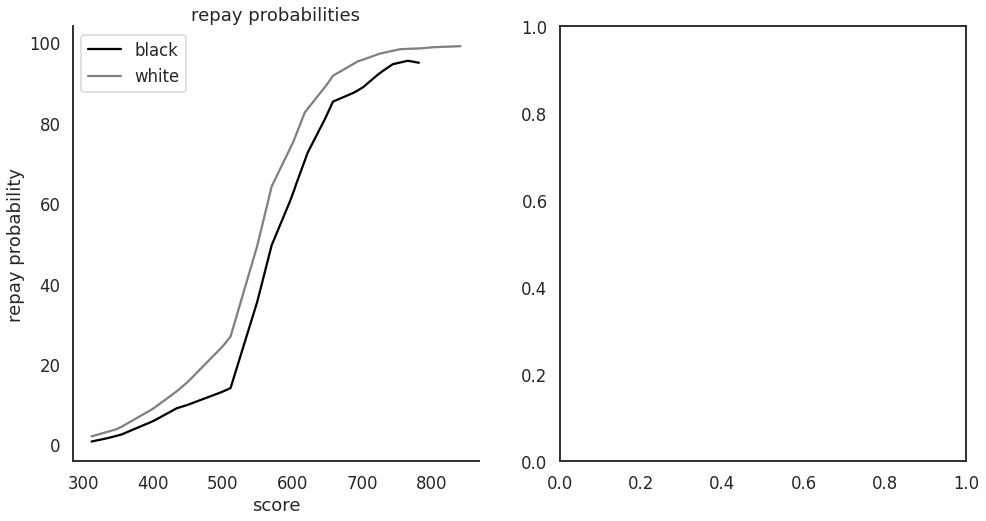

In [42]:
# Visualize the data, some figure code taken from FICO-figures.ipynb

# plot the repay probabilities
# TODO: figure out how to delete the second plot
fig, ax = plt.subplots(1,2,figsize=(16,8));


#ax[0].plot(scores_list,repay_A,color='black',label='black')
ax[0].plot(samples_A,samples_A_probs,color='black',label='black')
#ax[0].plot(scores_list,repay_B,label='white',color="grey")
ax[0].plot(samples_B,samples_B_probs,label='white',color="grey")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("repay probabilities")
ax[0].set_xlabel("score")
ax[0].set_ylabel("repay probability")
ax[0].legend()

In [ ]:
# TODO: try non linear regression
# Reference: https://scipy-cookbook.readthedocs.io/items/robust_regression.html

In [12]:
# NOTE: below won't work because data isn't linear

# Note: much of the linear regression code is adapted from the below link
# Reference: https://realpython.com/linear-regression-in-python/

'''
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

def run_linear_regression(x_arr, y_arr):
    # data prep
    x = x_arr.reshape(-1,1)
    y = y_arr
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
    
    # train model
    model = LinearRegression().fit(x_train, y_train)

    # analyze regression model on training set
    # NOTE: the intercept, b0 value or coefficient, tells us what the regression predicts if the x is zero
    #       the slope, b1 value, tells us how the predicted response rises/increases when x is increased by 1
    # QUESTION: not sure if the input for score here should be our train and test x and y values? or our test values?
    r_sq = model.score(x_train, y_train)
    print('coefficient of determination:', r_sq)
    print('intercept:', model.intercept_)
    print('slope/coef:', model.coef_)
    
    # get predictions
    y_pred = model.predict(x_test)
    print('predicted response:', y_pred, sep='\n')
    
    return model, y_test, y_pred

# NOTE: this function came from the Naomi Fridman's answer here 
# Reference: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
from sklearn import metrics

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

# Run linear regression on Group A -- Black

model_A, y_test_A, y_pred_A = run_linear_regression(samples_A, samples_A_probs)

# Analysis on Group A linear regression predictions
# NOTE: can't get regression results because some predicted values are negative...
regression_results(y_test_A, y_pred_A)

# Run linear regression on Group B -- White

model_B, y_test_B, y_pred_B = run_linear_regression(samples_B, samples_B_probs)

# Analysis on Group B linear regression predictions
# NOTE: can't get regression results because some predicted values are negative...
regression_results(y_test_B, y_pred_B)
'''

In [43]:
# NOTE: won't work because data isn't linear

# To run the below code, need sklearn version 0.24.1, so may need to update
#!pip3 install -U scikit-learn

# Run NNLS and OLS
# Reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_nnls.html

'''
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# data prep (currently set to do Group A)

x = samples_A.reshape(-1,1)
y = samples_A_probs
#print(x)
#print(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

reg_nnls = LinearRegression(positive=True)
y_pred_nnls = reg_nnls.fit(X_train, y_train).predict(X_test)
#print('NNLS predictions: ', y_pred_nnls)
print('NNLS coef: ', reg_nnls.coef_)
r2_score_nnls = r2_score(y_test, y_pred_nnls)
print("NNLS R2 score", r2_score_nnls)

# Fit an OLS
reg_ols = LinearRegression(positive=False)
y_pred_ols = reg_ols.fit(X_train, y_train).predict(X_test)
print('OLS coef: ', reg_ols.coef_)
r2_score_ols = r2_score(y_test, y_pred_ols)
print("OLS R2 score", r2_score_ols)

# Compare the regression coefficients between OLS and NNLS

fig, ax = plt.subplots()
ax.plot(reg_ols.coef_, reg_nnls.coef_, linewidth=0, marker=".")

low_x, high_x = ax.get_xlim()
low_y, high_y = ax.get_ylim()
low = max(low_x, low_y)
high = min(high_x, high_y)
ax.plot([low, high], [low, high], ls="--", c=".3", alpha=.5)
ax.set_xlabel("OLS regression coefficients", fontweight="bold")
ax.set_ylabel("NNLS regression coefficients", fontweight="bold")
'''

NNLS coef:  [0.26044257]
NNLS R2 score 0.8834274312018493
